<center>
    <h1><font size="16">Especialización en Estadística</font></h1>
    <h1><font size="12">SERIES DE TIEMPO</font></h1>
</center>

## 🎓 Taller Práctico – Evaluación de Modelos de Pronóstico en Series Temporales

### 📘 **Introducción**

En este taller exploraremos cómo evaluar y comparar el desempeño de modelos de pronóstico aplicados a series temporales. El objetivo no es ajustar nuevos modelos, sino analizar críticamente los **resultados de modelos previamente estimados** (por ejemplo, mediante `arima()` o `auto.arima()`), aplicando criterios objetivos para determinar cuál modelo ofrece un mejor ajuste y mayor capacidad predictiva.

Nos centraremos en tres aspectos clave:

1. **Evaluación con métricas de error**: analizaremos medidas como RMSE, MAE, MAPE y MASE para comparar modelos.
2. **Validación cruzada en series temporales**: aplicaremos técnicas específicas para evaluar el rendimiento fuera de muestra respetando la dependencia temporal.
3. **Análisis de errores**: examinaremos gráficamente los residuos y sus patrones para detectar problemas de ajuste y posibles mejoras.

> 🧠 Evaluar un modelo no solo implica calcular métricas, sino también interpretar sus resultados con base en los objetivos del análisis y la naturaleza de la serie.

---

### 🎯 **Objetivos del Taller**

* Aplicar métricas estándar (MAE, RMSE, MAPE, MASE) para comparar modelos de pronóstico.
* Implementar validación cruzada para evaluar el rendimiento fuera de muestra en series temporales.
* Interpretar los errores y residuos del modelo para guiar decisiones sobre la calidad del ajuste.
* Visualizar y comunicar de forma efectiva los resultados de la evaluación.

---

### 🧰 **Requisitos Previos**


In [2]:
# Cargar paquetes necesarios

library(fpp3)      # Framework moderno para modelado y evaluación de series temporales.
library(forecast)  # Funciones como accuracy(), tsCV(), forecast(), checkresiduals().
library(yardstick) # Métricas personalizadas en caso de modelos fuera de forecast/fable.
library(ggplot2)   # Visualización de resultados de error.
library(tsibble)   # Manipulación estructurada de series temporales.


Registered S3 method overwritten by 'tsibble':
  method               from 
  as_tibble.grouped_df dplyr

── Attaching packages ─────────────────────────────────────────────────────────────────────────────────── fpp3 1.0.1 ──

✔ tibble      3.2.1     ✔ tsibble     1.1.6
✔ dplyr       1.1.4     ✔ tsibbledata 0.4.1
✔ tidyr       1.3.1     ✔ feasts      0.4.1
✔ lubridate   1.9.4     ✔ fable       0.4.1
✔ ggplot2     3.5.2     

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────── fpp3_conflicts ──
✖ lubridate::date()    masks base::date()
✖ dplyr::filter()      masks stats::filter()
✖ tsibble::intersect() masks base::intersect()
✖ tsibble::interval()  masks lubridate::interval()
✖ dplyr::lag()         masks stats::lag()
✖ tsibble::setdiff()   masks base::setdiff()
✖ tsibble::union()     masks base::union()

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Registered S3 methods overwritten by

### 📥 **1. Carga y Transformación de los Datos**

En este taller trabajaremos nuevamente con la serie **AirPassengers**, una serie temporal clásica que contiene el número mensual de pasajeros de aerolíneas internacionales entre 1949 y 1960.

> Esta serie es útil por su comportamiento claramente **estacional y no estacionario**, lo que la convierte en un excelente ejemplo para el ajuste de modelos ARIMA estacionales.


In [3]:
# Cargar la serie AirPassengers desde forecast
data("AirPassengers")

# Visualizar la estructura de la serie
print(AirPassengers)

     Jan Feb Mar Apr May Jun Jul Aug Sep Oct Nov Dec
1949 112 118 132 129 121 135 148 148 136 119 104 118
1950 115 126 141 135 125 149 170 170 158 133 114 140
1951 145 150 178 163 172 178 199 199 184 162 146 166
1952 171 180 193 181 183 218 230 242 209 191 172 194
1953 196 196 236 235 229 243 264 272 237 211 180 201
1954 204 188 235 227 234 264 302 293 259 229 203 229
1955 242 233 267 269 270 315 364 347 312 274 237 278
1956 284 277 317 313 318 374 413 405 355 306 271 306
1957 315 301 356 348 355 422 465 467 404 347 305 336
1958 340 318 362 348 363 435 491 505 404 359 310 337
1959 360 342 406 396 420 472 548 559 463 407 362 405
1960 417 391 419 461 472 535 622 606 508 461 390 432


Transformamos la serie a formato `tsibble` y aplicamos una transformación logarítmica para estabilizar la varianza:


In [4]:
# Convertir a tsibble e incluir transformación logarítmica
library(tsibble)
library(dplyr)

ap_ts <- AirPassengers %>%
  as_tsibble(index = time) %>%
  mutate(log_ap = log(value))  # 'value' es el número de pasajeros

# Verificar los primeros valores
print(head(ap_ts))

# A tsibble: 6 x 3 [1M]
      index value log_ap
      <mth> <dbl>  <dbl>
1 1949 ene.   112   4.72
2 1949 feb.   118   4.77
3 1949 mar.   132   4.88
4 1949 abr.   129   4.86
5 1949 may.   121   4.80
6 1949 jun.   135   4.91


Visualicemos ambas versiones para entender la transformación aplicada:

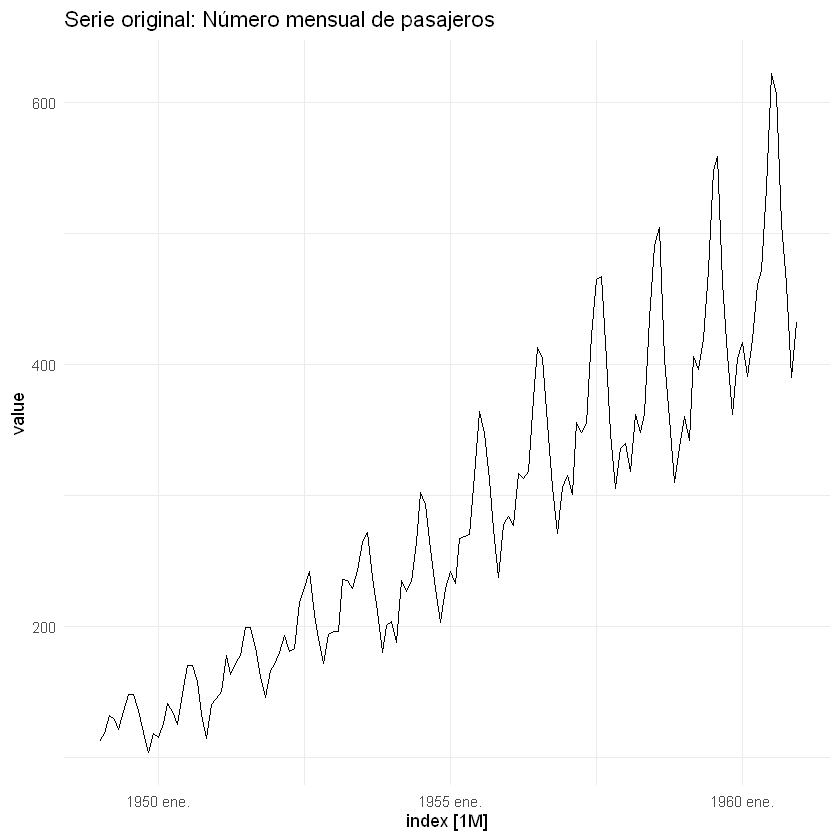

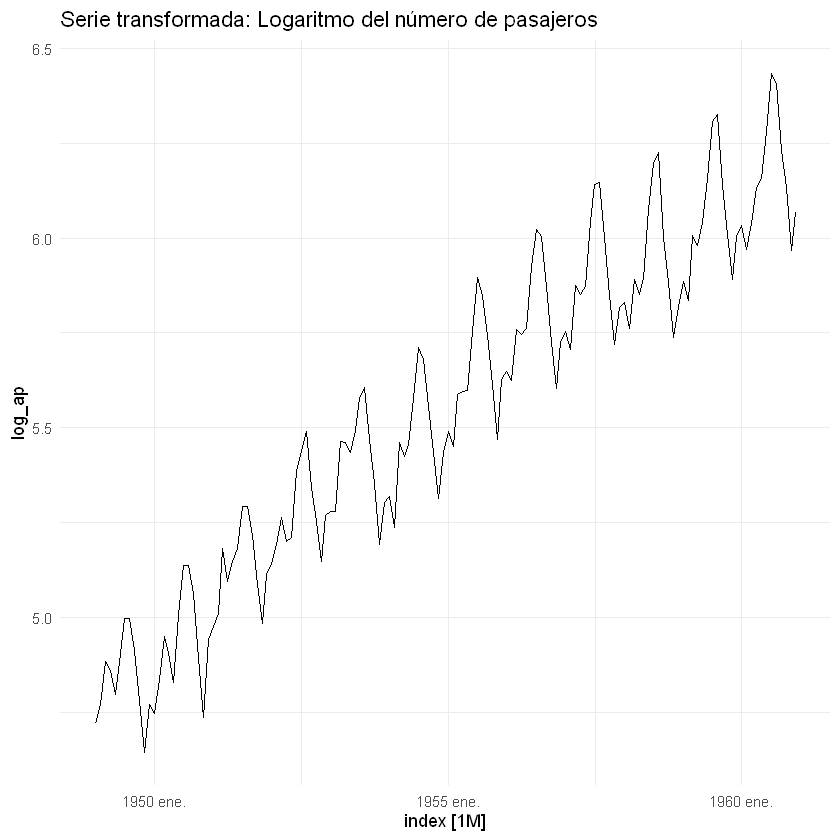

In [5]:
library(ggplot2)

# Comparación entre la serie original y la transformada
autoplot(ap_ts, value) + 
  ggtitle("Serie original: Número mensual de pasajeros") +
theme_minimal()

autoplot(ap_ts, log_ap) + 
  ggtitle("Serie transformada: Logaritmo del número de pasajeros") +
theme_minimal()


💬 **Pregunta de reflexión**:
> ¿Qué ventajas puede ofrecer la transformación logarítmica al momento de ajustar un modelo ARIMA?
> ¿Observas alguna diferencia en la varianza o comportamiento estacional tras la transformación?


### 📊 **2. Evaluación de Modelos ARIMA/SARIMA Ajustados**

Supongamos que ya contamos con varios modelos ajustados sobre la serie `log_ap`. En particular, vamos a trabajar con el modelo ajustado automáticamente mediante `auto.arima()` y un modelo ajustado manualmente, previamente identificado.

#### 🔧 Estimación previa de modelos (ya realizada):


In [6]:
library(forecast)

# Serie logarítmica y modelo ARIMA manual
log_ap <- log(AirPassengers)

mm <- arima(log_ap, order = c(1,1,1), seasonal = list(order = c(0,1,1), period = 12))

# Modelo automático
ma <- auto.arima(log_ap)


In [7]:
summary(mm)


Call:
arima(x = log_ap, order = c(1, 1, 1), seasonal = list(order = c(0, 1, 1), period = 12))

Coefficients:
         ar1      ma1     sma1
      0.1960  -0.5784  -0.5643
s.e.  0.2475   0.2132   0.0747

sigma^2 estimated as 0.001341:  log likelihood = 244.95,  aic = -481.9

Training set error measures:
                       ME       RMSE        MAE        MPE      MAPE      MASE
Training set 0.0006214598 0.03495868 0.02587023 0.01205363 0.4682203 0.2855888
                    ACF1
Training set -0.01530261

In [8]:
summary(ma)

Series: log_ap 
ARIMA(0,1,1)(0,1,1)[12] 

Coefficients:
          ma1     sma1
      -0.4018  -0.5569
s.e.   0.0896   0.0731

sigma^2 = 0.001371:  log likelihood = 244.7
AIC=-483.4   AICc=-483.21   BIC=-474.77

Training set error measures:
                       ME       RMSE        MAE        MPE      MAPE      MASE
Training set 0.0005730622 0.03504883 0.02626034 0.01098898 0.4752815 0.2169522
                   ACF1
Training set 0.01443892

### 📐 **Métricas de evaluación del pronóstico**

Utilizamos la función `forecast::accuracy()` para calcular métricas comunes de error en pronóstico:


In [9]:
# Pronóstico a 12 meses
h <- 12
pronostico_mm <- forecast(mm, h = h)

# Evaluación de precisión (dentro de muestra)
forecast::accuracy(pronostico_mm) %>%
  print()

                       ME       RMSE        MAE        MPE      MAPE      MASE
Training set 0.0006214598 0.03495868 0.02587023 0.01205363 0.4682203 0.2137293
                    ACF1
Training set -0.01530261


In [10]:
# Con el modelo automático
pronostico_ma <- forecast(ma, h = h)

# Evaluación de precisión (dentro de muestra)
forecast::accuracy(pronostico_ma) %>%
  print()

                       ME       RMSE        MAE        MPE      MAPE      MASE
Training set 0.0005730622 0.03504883 0.02626034 0.01098898 0.4752815 0.2169522
                   ACF1
Training set 0.01443892


### 🧠 **Interpretación orientada**

* ¿Qué modelo obtiene mejor desempeño fuera de muestra?
* ¿Se mantienen las ventajas del modelo automático frente al manual cuando evaluamos el pronóstico?
* ¿Qué ocurre con la MAPE o la MASE cuando nos alejamos del periodo de entrenamiento?
* ¿Qué impacto tiene la estacionalidad en el desempeño del modelo?

---

### 🧩 **Observación adicional**

En algunos casos, las métricas del modelo manual pueden no aparecer o retornar `NaN`, especialmente si:

* El modelo no genera un pronóstico válido por mal ajuste.
* La serie transformada no tiene valores disponibles para comparar con los pronósticos (por ejemplo, si no hemos separado un conjunto de validación).


### 📏 **Evaluación Alternativa con `yardstick` y Datos Simulados**

En esta sección exploraremos una forma alternativa de evaluar modelos de pronóstico: simularemos una situación en la que ya contamos con observaciones reales correspondientes al periodo de pronóstico. Esto nos permite calcular métricas como `rmse`, `mae`, `mape` o `rsq` usando el paquete `yardstick`.

> 🧪 Esta aproximación es especialmente útil cuando trabajamos con modelos que no son del tipo `forecast` (por ejemplo, modelos de Machine Learning), o cuando queremos un control más detallado del proceso.

#### 📦 **Paso 1: Crear tibble con observados y predichos**


In [11]:
library(tibble)
library(dplyr)
library(yardstick)

# Simular comparación para el modelo manual
df_resultados_mm <- tibble(
  y = tail(log_ap, h),                    # Observaciones (últimos 12 valores)
  y_hat = pronostico_mm$mean[1:h]        # Pronóstico del modelo manual
)

# Simular comparación para el modelo automático
df_resultados_ma <- tibble(
  y = tail(log_ap, h),                    # Observaciones (últimos 12 valores)
  y_hat = pronostico_ma$mean[1:h]        # Pronóstico del modelo automático
)


#### 📐 **Paso 2: Calcular métricas con `yardstick`**


In [12]:
# Evaluación del modelo manual
df_resultados_mm %>%
  metrics(truth = y, estimate = y_hat) %>%
  print()

# Evaluación del modelo automático
df_resultados_ma %>%
  metrics(truth = y, estimate = y_hat) %>%
  print()


# A tibble: 3 × 3
  .metric .estimator .estimate
  <chr>   <chr>          <dbl>
1 rmse    standard      0.0926
2 rsq     standard      0.987 
3 mae     standard      0.0909
# A tibble: 3 × 3
  .metric .estimator .estimate
  <chr>   <chr>          <dbl>
1 rmse    standard      0.0901
2 rsq     standard      0.987 
3 mae     standard      0.0884


### 💬 **Preguntas orientadoras**

* ¿Las métricas obtenidas con `yardstick` coinciden con las de `forecast::accuracy()`?
* ¿Qué ventajas ofrece este enfoque frente al anterior?
* ¿Cómo se podrían utilizar estas métricas en un contexto de validación cruzada o pruebas repetidas?

> 💡 *El uso de `yardstick` permite mayor flexibilidad, especialmente cuando usamos modelos fuera del ecosistema `forecast`, o cuando combinamos modelos clásicos con técnicas de aprendizaje automático.*


### 🔁 **Validación Cruzada en Series Temporales**

A diferencia de la validación cruzada tradicional (aleatoria), en series temporales es crucial respetar la **estructura secuencial del tiempo**. Por ello, empleamos métodos diseñados para evaluar el rendimiento de un modelo en distintos puntos del tiempo, proyectando únicamente hacia el futuro desde cada corte.

---

### 🔧 **Opción 1: Validación con `tsCV()` (paquete forecast)**

`tsCV()` calcula errores de pronóstico repetidos en distintos puntos del tiempo, proyectando `h` pasos hacia adelante desde cada observación disponible.


In [13]:
# Horizonte de pronóstico
h <- 12

# Función objetivo para aplicar tsCV con modelo ARIMA manual
errores_mm <- tsCV(log_ap, forecastfunction = function(y, h) {
  forecast(Arima(y, model = mm), h = h)
}, h = h)

# Cálculo del error cuadrático medio (RMSE) para el primer paso de pronóstico
sqrt(mean(errores_mm[, 1]^2, na.rm = TRUE))


[1] 0.03745608

In [14]:
# Función objetivo para aplicar tsCV con modelo ARIMA automático
errores_ma <- tsCV(log_ap, forecastfunction = function(y, h) {
  forecast(Arima(y, model = ma), h = h)
}, h = h)

# Cálculo del error cuadrático medio (RMSE) para el primer paso de pronóstico
sqrt(mean(errores_ma[, 1]^2, na.rm = TRUE))

[1] 0.03754072

### 🔧 **Opción 2: Validación con `stretch_tsibble()` (ecosistema `fpp3`)**

Este método permite simular ventanas crecientes o deslizantes de entrenamiento, útil para validar modelos entrenados con `fable`.


In [15]:
library(fabletools)

# Crear ventanas crecientes desde un mínimo de 60 observaciones
resamples <- ap_ts %>%
  stretch_tsibble(.init = 60, .step = 12)

In [16]:
# Entrenar modelo ARIMA con fable y evaluar pronósticos a 1 paso
modelo_cv <- resamples %>%
  model(arima = ARIMA(log_ap)) %>%
  forecast(h = 12) %>%
  forecast::accuracy(ap_ts)


Warning message:
"The future dataset is incomplete, incomplete out-of-sample data will be treated as missing. 
12 observations are missing between 1961 ene. and 1961 dic."


In [17]:

# Visualizar métricas promedio
modelo_cv %>%
  group_by(.model) %>%
  summarise(across(c(MAE, RMSE, MAPE, MASE), mean, na.rm = TRUE)) %>%
  print()

Warning message:
"There was 1 warning in `summarise()`.
ℹ In argument: `across(c(MAE, RMSE, MAPE, MASE), mean, na.rm = TRUE)`.
ℹ In group 1: `.model = "arima"`.
Caused by warning:
! The `...` argument of `across()` is deprecated as of dplyr 1.1.0.
Supply arguments directly to `.fns` through an anonymous function instead.

  # Previously
  across(a:b, mean, na.rm = TRUE)

  # Now
  across(a:b, \(x) mean(x, na.rm = TRUE))"


# A tibble: 1 × 5
  .model    MAE   RMSE  MAPE  MASE
  <chr>   <dbl>  <dbl> <dbl> <dbl>
1 arima  0.0424 0.0584 0.736 0.350


In [18]:
# Modelo especificado explícitamente como (0,1,1)(0,1,1)[12]
modelo_cva <- resamples %>%
  model(arima = ARIMA(log_ap ~ pdq(0,1,1) + PDQ(0,1,1))) %>%
  forecast(h = 12) %>%
  forecast::accuracy(ap_ts)


Warning message:
"The future dataset is incomplete, incomplete out-of-sample data will be treated as missing. 
12 observations are missing between 1961 ene. and 1961 dic."


In [19]:
# Visualizar métricas promedio
modelo_cva %>%
  group_by(.model) %>%
  summarise(across(c(MAE, RMSE, MAPE, MASE), mean, na.rm = TRUE)) %>%
  print()

# A tibble: 1 × 5
  .model    MAE   RMSE  MAPE  MASE
  <chr>   <dbl>  <dbl> <dbl> <dbl>
1 arima  0.0410 0.0539 0.701 0.339



### 💬 **Preguntas para discusión**

* ¿Qué ventajas ofrece `tsCV()` frente a un único corte de entrenamiento y prueba?
* ¿Qué implicaciones tiene la elección del horizonte `h` en el error obtenido?
* ¿Notas alguna diferencia en la estabilidad del error según la técnica usada?
* ¿Qué estrategias de validación usarías en un caso con datos altamente estacionales?

---

> 💡 *Validar un modelo de series temporales implica más que medir su ajuste; se trata de entender su comportamiento ante distintos escenarios de predicción, especialmente fuera de muestra.*
